# 勾配法と誤差逆伝播法
**誤差逆伝播法(back-propagation)**
## ニューラルネットワークモデル
この節では入力層，隠れ層，出力層からなる3層ニューラルネットワークを実装する．

In [13]:
using Base: @kwdef
using Parameters: @unpack # or using UnPack
using LinearAlgebra, Random, Statistics, PyPlot, ProgressMeter

In [2]:
abstract type NeuralNet end

@kwdef mutable struct MLP <: NeuralNet
    bias::Bool
    L::Int # num. of layers
    f::Vector{Function}; ∇f::Vector{Function};
    params::Dict{String, Array} # weights and bias
    grads::Dict{String, Array} = Dict() # gradient of params
    states::Dict{String, Array} = Dict() # state of forward/backward activity
end;

function MLP(num_units; activation="sigmoid", bias=true)
    params = Dict{String, Array}()
    L = length(num_units) - 1
    for l in 1:L
        # initialization of parameters
        params["W$l"] = 2 * (rand(num_units[l], num_units[l+1]) .- 0.5) / sqrt(num_units[l])
        if bias
            params["b$l"] = zeros(1, num_units[l+1])
        end
    end
    if activation isa Vector{String}
        @assert length(activation) == L "length of activation must be equal to L=$L, or use string"
        f = [eval(Symbol(activation[l])) for l in 1:L]
        ∇f = [eval(Symbol("∇$(activation[l])")) for l in 1:L]
    elseif activation isa String
        f = [eval(Symbol(activation)) for l in 1:L]
        ∇f = [eval(Symbol("∇$(activation)")) for l in 1:L]
    end
    return MLP(bias=bias, L=L, params=params, f=f, ∇f=∇f)
end;

In [3]:
params = Dict{String, Array}()
num_units = [10, 20, 30]
L = length(num_units) - 1
# initialization of parameters
params["W"] = [2 * (rand(num_units[l], num_units[l+1]) .- 0.5) / sqrt(num_units[l]) for l in 1:L]
params["b"] = [zeros(1, num_units[l+1]) for l in 1:L]

2-element Vector{Matrix{Float64}}:
 [0.0 0.0 … 0.0 0.0]
 [0.0 0.0 … 0.0 0.0]

In [14]:
@unpack W, b = params

Dict{String, Array} with 2 entries:
  "W" => [[-0.141363 -0.0871712 … -0.109696 -0.245738; 0.152317 -0.204654 … -0.…
  "b" => [[1.0 1.0 … 1.0 1.0], [0.0 0.0 … 0.0 0.0]]

In [ ]:
@unpack W, b = params    # parameters
@unpack ∇W, ∇b = grads # gradient of params
@unpack a, z, δ = states # state of forward/backward activity

In [18]:
d = Dict()
d["W"] = Dict()

Dict{Any, Any}()

In [19]:
d["W"][0] = 1

1

In [20]:
keys(d)
for key in keys(d)
    for l in 1:L
        
    

KeySet for a Dict{Any, Any} with 1 entry. Keys:
  "W"

In [16]:
params["b"]

2-element Vector{Matrix{Float64}}:
 [2.0 2.0 … 2.0 2.0]
 [0.0 0.0 … 0.0 0.0]

mutable struct `MLP`を用意し，**重みの初期化(weight initialization)** を行う同名の関数`MLP`を用意する．重みの初期化の手法は複数ある(Glorot & Bengio, 2010)が，ここでは重みを$W$として，$w \sim U\left(-1/\sqrt{n}, 1/\sqrt{n}\right)$とする．ただし，$n$は入力ユニット数である．

### 順伝播 (forward propagation)
$f(\cdot)$を活性化関数とする．順伝播(feedforward propagation)は以下のようになる．

$$
\begin{align}
\text{入力層 : }&\mathbf{z}^{(0)}=\mathbf{x}\\
\text{隠れ層 : }&\mathbf{z}^{(\ell)}=f\left(\mathbf{a}^{(\ell)}\right)\\
&\mathbf{a}^{(\ell+1)}=W^{(\ell+1)}\mathbf{z}^{(\ell)}+\mathbf{b}^{(\ell+1)}\\
\text{出力層 : }&\hat{\mathbf{y}}=\mathbf{z}^{(L)}
\end{align}
$$

In [3]:
sigmoid(x) = 1 ./ (1 .+ exp.(-x));
relu(x) = max.(x, 0);

∇sigmoid(z) = z .* (1 .- z)
∇relu(z) = z .> 0
∇tanh(z) = 1 .- z.^2

∇tanh (generic function with 1 method)

In [73]:
function softmax(x; dims=1)
    expx = exp.(x .- maximum(x))
    return expx ./ sum(expx, dims=dims)
end

softmax (generic function with 1 method)

In [ ]:
∇softmax

最後に活性化関数を付けたくない場合は恒等関数 `identity` を用いる．

In [4]:
function forward!(mlp::MLP, x::Array)
    @unpack bias, L, params, states, f = mlp
    states["z0"] = x
    for l in 1:L
        states["a$l"] = states["z$(l-1)"] * params["W$l"]
        if bias
            states["a$l"] += params["b$l"]
        end
        states["z$l"] = f[l](states["a$l"])
    end
    return states["z$L"]
end

forward! (generic function with 1 method)

### 逆伝播 (backward propagation)

$$
\begin{align}
\text{目的関数 : }&\mathcal{L}=\frac{1}{2}\left\|\hat{\mathbf{y}}-\mathbf{y}\right\|^{2}\\
\text{最急降下法 : }&\Delta W^{(\ell)}=-\eta \frac{\partial \mathcal{L}}{\partial W^{(\ell)}}\\
&\Delta \mathbf{b}^{(\ell)}=-\eta \frac{\partial \mathcal{L}}{\partial \mathbf{b}^{(\ell)}}\\
\text{誤差逆伝播法 : }&\frac{\partial \mathcal{L}}{\partial \hat{\mathbf{y}}}=\frac{\partial \mathcal{L}}{\partial \mathbf{z}^{(L)}}=\hat{\mathbf{y}}-\mathbf{y}\\
&\delta^{(L)}=\frac{\partial \mathcal{L}}{\partial \mathbf{z}^{(L)}} \frac{\partial \mathbf{z}^{(L)}}{\partial \mathbf{a}^{(L)}}=\left(\hat{\mathbf{y}}-\mathbf{y}\right) \odot f^{\prime}\left(\mathbf{a}^{(L)}\right)\\
&\mathbf{\delta}^{(\ell)}=\frac{\partial \mathcal{L}}{\partial \mathbf{z}^{(\ell)}} \frac{\partial \mathbf{z}^{(\ell)}}{\partial \mathbf{a}^{(\ell)}}=\left(W^{(\ell+1)}\right)^\top \delta^{(\ell+1)} \odot f^{\prime}\left(\mathbf{a}^{(\ell)}\right)\\
&\frac{\partial \mathcal{L}}{\partial W^{(\ell)}}=\frac{\partial \mathcal{L}}{\partial \mathbf{z}^{(\ell)}} \frac{\partial \mathbf{z}^{(\ell)}}{\partial \mathbf{a}^{(\ell)}} \frac{\partial \mathbf{a}^{(\ell)}}{\partial W^{(\ell)}}=\delta^{(\ell)}\left(\mathbf{z}^{(\ell-1)}\right)^\top\\
&\frac{\partial \mathcal{L}}{\partial \mathbf{b}^{(\ell)}}=\frac{\partial \mathcal{L}}{\partial \mathbf{z}^{(\ell)}} \frac{\partial \mathbf{z}^{(\ell)}}{\partial \mathbf{a}^{(\ell)}} \frac{\partial \mathbf{a}^{(\ell)}}{\partial \mathbf{b}^{(\ell)}}=\delta^{(\ell)}
\end{align}
$$

バッチ処理を考慮すると，行列を乗ずる順番が変わる．

以下では$z=f(a), g(z)=f'(a)$として膜電位を使わず，発火率情報のみを使うようにしている．このようにできない関数もあるが，今回はこのように書き下せる活性化関数のみを扱う．

$$
\frac{d}{dx} \text{Sigmoid}(x) = \text{Sigmoid}(x) \cdot \left(1 - \text{Sigmoid}(x)\right)
$$
であることに注意．

In [5]:
function backward!(mlp::MLP; losstype::String="binary_crossentropy")
    @unpack bias, L, params, states, grads, ∇f = mlp
    n_batch = size(states["z0"])[1]
    # backprop
    for l in L:-1:1
        if l > 1
            states["δ$(l-1)"] = states["δ$l"] * params["W$l"]' .* ∇f[l].(states["z$(l-1)"])
        end
        grads["W$l"] = states["z$(l-1)"]' * states["δ$l"] / n_batch
        if bias
            grads["b$l"] = sum(states["δ$l"], dims=1) / n_batch
        end
    end
end

backward! (generic function with 1 method)

In [43]:
clog(x) = max(log(x), -1e2) # clamped log

function binary_crossentropy!(nn::NeuralNet, ŷ::Array, y::Array)
    @unpack L, states = nn
    error = ŷ - y
    loss = sum(-y .* clog.(ŷ) + (1 .- y) .* clog.(1 .- ŷ))
    states["δ$L"] = error
    return loss
end

function squared_error!(nn::NeuralNet, ŷ::Array, y::Array)
    @unpack L, states, ∇f = mlp
    error = ŷ - y
    loss = sum(error .^ 2)
    states["δ$L"] = error .* ∇f[L].(ŷ)
    return loss
end

squared_error! (generic function with 1 method)

### Optimizerの作成
abstract typeとして`Optimizer`タイプを作成する．

In [7]:
abstract type Optimizer end

**確率的勾配降下法(stochastic gradient descent; SGD)** を実装する．

In [8]:
# SGD optimizer
@kwdef struct SGD{FT} <: Optimizer
    η::FT = 1e-2
end

function optimizer_update!(param, grad, optimizer::SGD)
    @unpack η = optimizer
    param[:, :] -= η * grad
end

optimizer_update! (generic function with 1 method)

次に**Adam** ([Kingma & Ba, 2014](https://arxiv.org/abs/1412.6980)) を実装する．

In [9]:
# Adam optimizer
@kwdef mutable struct Adam{FT} <: Optimizer
    α::FT  = 1e-4; β1::FT = 0.9; β2::FT = 0.999; ϵ::FT = 1e-8
    ms = Dict(); vs = Dict();
end

# Adam optimizer
function optimizer_update!(param, grad, optimizer::Adam)
    @unpack α, β1, β2, ϵ, ms, vs = optimizer
    key = objectid(param)
    if !haskey(ms, key) 
        ms[key], vs[key] = zeros(size(param)), zeros(size(param))
    end    
    m, v = ms[key], vs[key]
    m += (1 - β1) * (grad - m)
    v += (1 - β2) * (grad .* grad - v)
    param[:, :] -= α * m ./ (sqrt.(v) .+ ϵ)
end

optimizer_update! (generic function with 2 methods)

In [10]:
function optim_step!(nn::NeuralNet, optimizer::Optimizer)
    @unpack params, grads = nn
    for key in keys(params)
        optimizer_update!(params[key], grads[key], optimizer)
    end
end

optim_step! (generic function with 1 method)

In [25]:
function train_step!(nn::NeuralNet, x::Array, y::Array, loss_fun::Function, optimizer::Optimizer=SGD())
    ŷ = forward!(nn, x)
    loss = loss_fun(nn, ŷ, y)
    backward!(nn)
    optim_step!(nn, optimizer) # update params
    return loss
end

train_step! (generic function with 2 methods)

## MNIST

## Zipser-Andersenモデル
Zipser-Andersenモデル {cite:p}`Zipser1988-nc` は頭頂葉の7a野のモデルであり，網膜座標系における物体の位置と眼球位置を入力として，頭部中心座標(head centered coordinate)に変換する．隠れ層はPPC(Posterior parietal cortex)の細胞のモデルになっている．

### データセットの生成
物体位置の表現にはGaussian形式とmonotonic形式があるが，簡単のために，Gaussian形式を用いる．なお，monotonic形式については末尾の補足を参照してほしい．

In [26]:
# Gaussian 2d
function Gaussian2d(pos, sizex=8, sizey=8, σ=1)
    x, y = 0:sizex-1, 0:sizey-1
    X, Y = [i for i in x, j in 1:length(y)], [j for i in 1:length(x), j in y]
    x0, y0 = pos
    return exp.(-((X .- x0) .^2 + (Y .- y0) .^2) / 2σ^2)
end

Gaussian2d (generic function with 4 methods)

入力は64(網膜座標系での位置)+2(眼球位置信号)=66とする．眼球位置信号は原著ではmonotonic形式による32(=8ユニット×2(x, y方向)×2 (傾き正負))ユニットで構成されるが，簡単のために眼球位置信号も$x, y$の2次元とする．視覚刺激は-40度から40度までの範囲であり，10度で離散化する．よって，網膜座標系での位置は$8\times 8$の行列で表現される．位置は2次元のGaussianで表現する．ただし，1/e幅（ピークから1/eに減弱する幅）は15度である．$1/e$の代わりに$1/2$とすれば半値全幅(FWHM)となる．スポットサイズを$W$，Gaussianを$G(x)$とすると．$G(x+w/2)=G/e$より，$\sigma=\frac{\sqrt{2}w}{4}$と求まる．

In [27]:
# dataset θeter
θmax = 40.0 # degree, θ∈[-θmax, θmax]
Δθ = 10.0 # degree
stimuli_size = Int(2θmax / Δθ)
w = 15.0 # degree; 1/e width
σ = √2w/(4Δθ);

# training θeter
n_data = 10000
n_traindata = Int(n_data*0.95)
n_batch = 100 # batch size
n_iter_per_epoch = Int(n_traindata/n_batch)
n_epoch = 2000; # number of epoch

In [28]:
# generate positions
Random.seed!(0)
retinal_pos = (rand(n_data, 2) .- 0.5) * 2θmax # ∈ [-40, 40]
head_centered_pos = (rand(n_data, 2) .- 0.5) * 2θmax # ∈ [-40, 40]
#retinal_pos = (rand(n_data, 2) .- 0.5) * 2θmax # ∈ [-40, 40]
#head_centered_pos = (rand(n_data, 2) .- 0.5) * 2θmax # ∈ [-40, 40]
eye_pos = head_centered_pos - retinal_pos; # ∈ [-80, 80]

# convert
input_retina = [hcat(Gaussian2d((retinal_pos[i, :] .+ θmax)/Δθ, stimuli_size, stimuli_size, σ)...) for i in 1:n_data];
input_retina = vcat(input_retina...)
eye_pos /= 2θmax;

# concat
x_data = hcat(input_retina, eye_pos) #_encoded)
y_data = vcat([hcat(Gaussian2d((head_centered_pos[i, :] .+ θmax)/Δθ, stimuli_size, stimuli_size, σ)...) for i in 1:n_data]...);

# split
x_traindata, y_traindata = x_data[1:n_traindata, :], y_data[1:n_traindata, :]
x_testdata, y_testdata = x_data[n_traindata+1:end, :], y_data[n_traindata+1:end, :];

In [29]:
product(sets...) = hcat([collect(x) for x in Iterators.product(sets...)]...)' # Array of Cartesian product of sets 

product (generic function with 1 method)

モデルの定義を行う．

In [30]:
# model θeter
n_in = stimuli_size^2 + 2 # number of inputs
n_hid = 16   # number of hidden units
n_out = stimuli_size^2   # number of outputs
η = 1e-2  # learning rate
#losstype = "binary_crossentropy" # "squared_error"

0.01

In [44]:
nn = MLP([n_in, n_hid, n_out], bias=false)
optimizer = SGD(η=η); 
loss_fun = binary_crossentropy!
#optimizer = Adam();

binary_crossentropy! (generic function with 1 method)

In [32]:
n_in, n_hid, n_out

(66, 16, 64)

学習を行う．

In [45]:
error_arr = zeros(n_epoch); # memory array of each epoch error

@showprogress "Training..." for e in 1:n_epoch
    for iter in 1:n_iter_per_epoch
        idx = (iter-1)*n_batch+1:iter*n_batch
        x, y = x_traindata[idx, :], y_traindata[idx, :]
        loss = train_step!(nn, x, y, loss_fun, optimizer)
        error_arr[e] += loss
    end 
    error_arr[e] /= n_traindata
end

Training... 100%|████████████████████████████████████████| Time: 0:01:04mm9mmmm


損失の変化を描画する．

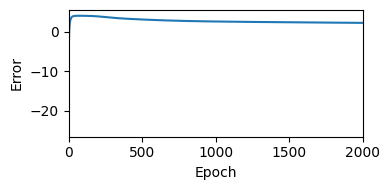

In [50]:
figure(figsize=(4,2))
#semilogy(error_arr)
plot(error_arr)
ylabel("Error"); xlabel("Epoch"); xlim(0, n_epoch)
tight_layout()

テストデータを用いて，出力を確認する．

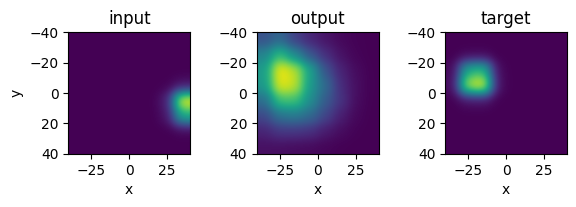

In [48]:
x, y = x_testdata[1:2, :], y_testdata[1:2, :]
ŷ = forward!(nn, x)

id = 1
figure(figsize=(6,2))
ax1 = subplot(1,3,1); title("input")
ax1.imshow(reshape(x[id, 1:64], (stimuli_size, stimuli_size))', interpolation="gaussian", extent=[-θmax, θmax, θmax, -θmax])
ax1.add_patch(plt.Circle((x[id, 65:66])*2θmax, radius=2, color="tab:red", fill=false))
xlabel("x"); ylabel("y");

ax2 = subplot(1,3,2); title("output")
ax2.imshow(reshape(ŷ[id, :], (stimuli_size, stimuli_size))', interpolation="gaussian", extent=[-θmax, θmax, θmax, -θmax])
ax2.add_patch(plt.Circle((x[id, 65:66])*2θmax, radius=2, color="tab:red", fill=false))
xlabel("x");

ax3 = subplot(1,3,3); title("target")
ax3.imshow(reshape(y[id, :], (stimuli_size, stimuli_size))', interpolation="gaussian", extent=[-θmax, θmax, θmax, -θmax])
ax3.add_patch(plt.Circle((x[id, 65:66])*2θmax, radius=2, color="tab:red", fill=false))
xlabel("x");

tight_layout()

重み`W1`におけるゲインフィールドの描画を行う．

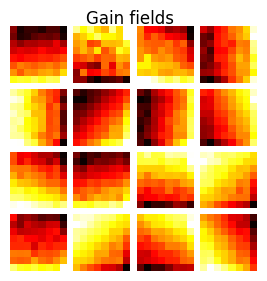

In [49]:
# Plot Gain fields
figure(figsize=(3.2, 3))
suptitle("Gain fields", fontsize=12)
subplots_adjust(hspace=0.1, wspace=0.1, top=0.925)
for i in 1:n_hid
    #subplot(3, 3, i)
    subplot(4, 4, i)
    imshow(reshape(nn.params["W1"][1:stimuli_size^2, i], (stimuli_size, stimuli_size)), cmap="hot")
    axis("off")
end

## 補足：Monotonic formatによる位置のエンコーディング
monotonic形式を入力の眼球位置と出力の頭部中心座標で用いるという仮定には，視覚刺激を中心窩で捉えた際，得られる眼球位置信号を頭部中心座標での位置の教師信号として使用できるという利点がある．([Andersen & Mountcastle, J. Neurosci. 1983](https://pubmed.ncbi.nlm.nih.gov/6827308/))では Parietal visual neurons (PVNs)の活動を調べ，傾き正あるいは負．0度をピークとして減少あるいは上昇の4種類あることを示した．前者は一次関数（とReLU関数）で記述可能である．

In [23]:
get_line(p1, p2) = [(p2[2]-p1[2])/(p2[1]-p1[1]), (p2[1]*p1[2] - p1[1]*p2[2])/(p2[1]-p1[1])] # [slope, intercept]
eye_pos_coding(x; linear_θ) = relu.(linear_θ[1, :] * x .+ linear_θ[2, :])

x = -2θmax:1:2θmax
slope_θ = hcat([get_line([80, 1], [-80, -2(i-1)/stimuli_size]) for i in 1:stimuli_size]...)
y = hcat(eye_pos_coding.(x; linear_θ=slope_θ)...)
eye_pos_encoded = eye_pos_coding(-10; linear_θ=slope_θ)

8-element Vector{Float64}:
 0.4375
 0.296875
 0.15625
 0.015625
 0.0
 0.0
 0.0
 0.0

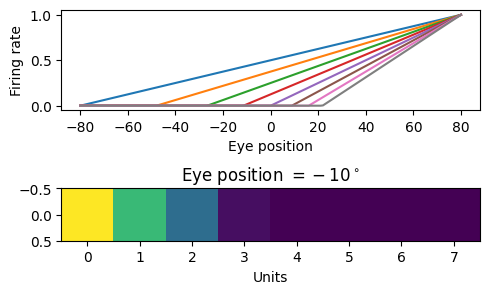

In [24]:
figure(figsize=(5,3))
subplot(2,1,1); plot(x, y'); xlabel("Eye position"); ylabel("Firing rate")
subplot(2,1,2); imshow(eye_pos_encoded[:, :]'); title(L"Eye position $=-10^\circ$"); xlabel("Units") 
tight_layout()

## 参考文献
```{bibliography}
:filter: docname in docnames
```